In [1]:
%who

Interactive namespace is empty.


In [29]:
import xarray as xr
import numpy as np
import geopandas as gpd
import datetime
import matplotlib
import pandas as pd
import seaborn as sns

%run -i drought_2017to2019/dataInfo_and_functions.py

def calc_areaAvg(da, latName = 'lat', lonName = 'lon'): 
    weights = np.cos(np.deg2rad(da[latName]))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean([latName, lonName])
    return weighted_mean

# function to calculate regAvg anom
def calc_regAvg_monAnom_masked(da_monAnom, da_monRef, da_mask):
    da_anom_regAvg = calc_areaAvg(da_monAnom*da_mask)
    da_ref_regAvg = calc_areaAvg(da_monRef*da_mask)
    da_ref_regAvg_forPerc = da_ref_regAvg.sel(month = da_anom_regAvg['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_regAvg.time.values})
    da_anom_regAvg_perc = da_anom_regAvg/da_ref_regAvg_forPerc*100
    return [da_anom_regAvg, da_anom_regAvg_perc]

In [3]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/precip_data/'

agcd_file1 = 'agcd_monthly_1900_2020.nc'
agcd_file2 = 'precip_agcd_monthly_2020_2022.nc'

chirps_file = 'chirps_monthly_1981_2021.nc'
mswep_file = 'precipitation_mswep_monthly_1979_2021.nc'

# get data upto the end of year 2019 from this file
ds_agcd1 = xr.open_dataset(data_dir + agcd_file1)
ds_agcd1 = ds_agcd1.sel(time = slice(None, '2019'))

# get data for 2020 to 2021 from this file & reassign the time coords
ds_agcd2 = xr.open_dataset(data_dir + agcd_file2)
ds_agcd2 = ds_agcd2.sel(time = slice('2020', '2021'))
ds_agcd2 = ds_agcd2.assign_coords({'time': ds_agcd2.time.values +  pd.Timedelta(-15, 'D')})

# the concated agcd data
ds_agcd = xr.concat([ds_agcd1, ds_agcd2], dim = 'time')

ds_chirps = xr.open_dataset(data_dir + chirps_file)
ds_mswep = xr.open_dataset(data_dir + mswep_file)

In [5]:
# the monthly climatology from long-term data
# time_slice = slice('1981-01-01', '2020-05-31')

time_slice = slice('1980-01-01', '2016-12-31')  # using the agreed time reference

da_agcd_lt_monClim = ds_agcd['precip'].sel(time = time_slice).groupby('time.month').mean('time')
da_chirps_lt_monClim = ds_chirps['precip'].sel(time = time_slice).groupby('time.month').mean('time')
da_mswep_lt_monClim = ds_mswep['precipitation'].sel(time = time_slice).groupby('time.month').mean('time')

# the monthly anomalies during the drought period
time_slice = slice('2016-01-01', '2020-12-31')
da_agcd_monAnom = ds_agcd['precip'].sel(time = time_slice).groupby('time.month') - da_agcd_lt_monClim
da_chirps_monAnom = ds_chirps['precip'].sel(time = time_slice).groupby('time.month') - da_chirps_lt_monClim
da_mswep_monAnom = ds_mswep['precipitation'].sel(time = time_slice).groupby('time.month') - da_mswep_lt_monClim

In [8]:
# get a region mask using the drought focus region shapefile
import regionmask

# read in the focus region shapefile
drought_focusReg = gpd.read_file('/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp')

# data_list = [da_agcd, da_chirps, da_mswep]
# data_names = ['AGCD', 'CHIRPS', 'MSWEP']

# for iDat in range(len(data_list)):
#     # create a mask of the polygon for the lat-long values in ds. The mask would contain '0' inside the region; nan otherwise
#     da_mask_zeros = regionmask.mask_geopandas(geodataframe = drought_focusReg, lon_or_obj = data_list[iDat].lon.values, lat = data_list[iDat].lat.values)
#     # setting the points inside the region to 1
#     da_mask = xr.where(da_mask_zeros == 0, 1, np.nan)

#     # save the mask into a netcdf file
#     out_file = '/g/data/w97/ad9701/drought_2017to2020/' + data_names[iDat] + '_mask_drought_focusArea.nc'
#     da_mask.to_netcdf(out_file)

# read mask from saved files
mask_file = '/g/data/w97/ad9701/drought_2017to2020/AGCD_mask_drought_focusArea.nc'
ds_agcd_mask = xr.open_dataset(mask_file)
da_agcd_mask = ds_agcd_mask['mask']

mask_file = '/g/data/w97/ad9701/drought_2017to2020/CHIRPS_mask_drought_focusArea.nc'
ds_chirps_mask = xr.open_dataset(mask_file)
da_chirps_mask = ds_chirps_mask['mask']

mask_file = '/g/data/w97/ad9701/drought_2017to2020/MSWEP_mask_drought_focusArea.nc'
ds_mswep_mask = xr.open_dataset(mask_file)
da_mswep_mask = ds_mswep_mask['mask']

agcd_anom_list = calc_regAvg_monAnom_masked(da_agcd_monAnom, da_agcd_lt_monClim, da_agcd_mask)
chirps_anom_list = calc_regAvg_monAnom_masked(da_chirps_monAnom, da_chirps_lt_monClim, da_chirps_mask)
mswep_anom_list = calc_regAvg_monAnom_masked(da_mswep_monAnom, da_mswep_lt_monClim, da_mswep_mask)

# assign agcd time dimension to the other two datasets (this time dimension uses the mid point of each month instead of the start)
for i in range(2):
    chirps_anom_list[i] = chirps_anom_list[i].assign_coords({'time':agcd_anom_list[i].time.values})
    mswep_anom_list[i] = mswep_anom_list[i].assign_coords({'time':agcd_anom_list[i].time.values})
    
da_precip_allData = xr.concat([agcd_anom_list[0], chirps_anom_list[0], mswep_anom_list[0]], dim = 'dataset')
da_precip_monAnomAvg_regAvg = da_precip_allData.mean('dataset')

da_perc_precip_allData = xr.concat([agcd_anom_list[1], chirps_anom_list[1], mswep_anom_list[1]], dim = 'dataset')
da_perc_precip_monAnomAvg_regAvg = da_perc_precip_allData.mean('dataset')

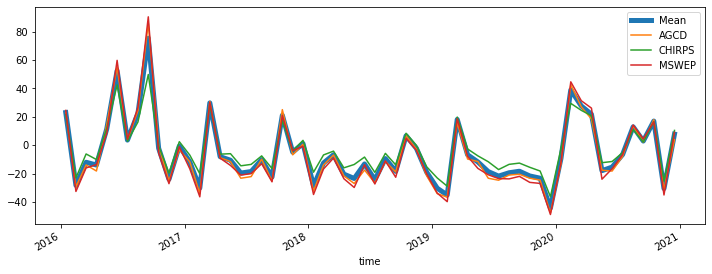

In [9]:
import matplotlib.pyplot as plt
da_precip_monAnomAvg_regAvg.plot(size=4, aspect=3,label='Mean', linewidth=5)
agcd_anom_list[0].plot(label='AGCD')
chirps_anom_list[0].plot(label='CHIRPS')
mswep_anom_list[0].plot(label='MSWEP')
plt.legend()

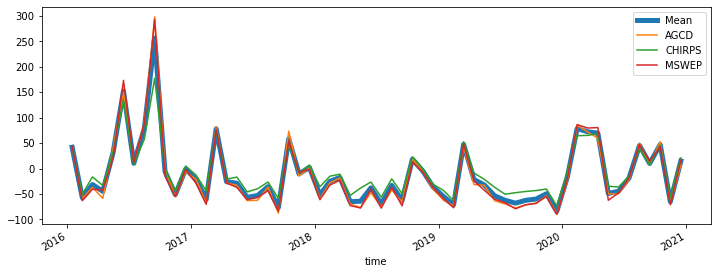

In [10]:
da_perc_precip_monAnomAvg_regAvg.plot(size=4, aspect=3,label='Mean', linewidth=5)
agcd_anom_list[1].plot(label='AGCD')
chirps_anom_list[1].plot(label='CHIRPS')
mswep_anom_list[1].plot(label='MSWEP')
plt.legend()

### ET

In [11]:
# get a region mask using the drought focus region shapefile
import regionmask

# read in the focus region shapefile
drought_focusReg = gpd.read_file('/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp')

# data_list = [ds_era5land['e'].isel(time = 0), ds_gleam['E'].isel(time = 0), ds_awra['etot'].isel(time = 0)]
data_names = ['ERA5Land', 'GLEAM', 'AWRA']

# for iDat in range(len(data_list)):
#     # create a mask of the polygon for the lat-long values in ds. The mask would contain '0' inside the region; nan otherwise
#     da_mask_zeros = regionmask.mask_geopandas(geodataframe = drought_focusReg, lon_or_obj = data_list[iDat].lon.values, lat = data_list[iDat].lat.values)
#     # setting the points inside the region to 1
#     da_mask = xr.where(da_mask_zeros == 0, 1, np.nan)

#     # save the mask into a netcdf file
#     out_file = '/g/data/w97/ad9701/drought_2017to2020/' + data_names[iDat] + '_mask_drought_focusArea.nc'
#     da_mask.to_netcdf(out_file)

# read mask from saved files
mask_file = '/g/data/w97/ad9701/drought_2017to2020/ERA5Land_mask_drought_focusArea.nc'
ds_era5land_mask = xr.open_dataset(mask_file)
da_era5land_mask = ds_era5land_mask['mask']

mask_file = '/g/data/w97/ad9701/drought_2017to2020/GLEAM_mask_drought_focusArea.nc'
ds_gleam_mask = xr.open_dataset(mask_file)
da_gleam_mask = ds_gleam_mask['mask']

mask_file = '/g/data/w97/ad9701/drought_2017to2020/AWRA_mask_drought_focusArea.nc'
ds_awra_mask = xr.open_dataset(mask_file)
da_awra_mask = ds_awra_mask['mask']

data_dir = '/g/data/w97/ad9701/drought_2017to2020/ET_data/'
era5land_file = 'e_era5land_monthly_1950_2022.nc'
gleam_file = 'E_gleam_monthly_1980_2020.nc'
awra_file = 'etot_awra_monthly_1911_2022.nc'

ds_era5land = xr.open_dataset(data_dir + era5land_file)
ds_gleam = xr.open_dataset(data_dir + gleam_file)
ds_awra = xr.open_dataset(data_dir + awra_file)

# the monthly climatology from long-term data
time_slice = slice('1980-01-01', '2016-12-31')
da_era5land_lt_monClim = ds_era5land['e'].sel(time = time_slice).groupby('time.month').mean('time')
da_gleam_lt_monClim = ds_gleam['E'].sel(time = time_slice).groupby('time.month').mean('time')
da_awra_lt_monClim = ds_awra['etot'].sel(time = time_slice).groupby('time.month').mean('time')

# the monthly anomalies during the drought period
time_slice = slice('2016-01-01', '2020-12-31')
da_era5land_monAnom = ds_era5land['e'].sel(time = time_slice).groupby('time.month') - da_era5land_lt_monClim
da_gleam_monAnom = ds_gleam['E'].sel(time = time_slice).groupby('time.month') - da_gleam_lt_monClim
da_awra_monAnom = ds_awra['etot'].sel(time = time_slice).groupby('time.month') - da_awra_lt_monClim

In [12]:
era5land_anom_list = calc_regAvg_monAnom_masked(da_era5land_monAnom, da_era5land_lt_monClim, da_era5land_mask)
gleam_anom_list = calc_regAvg_monAnom_masked(da_gleam_monAnom, da_gleam_lt_monClim, da_gleam_mask)
awra_anom_list = calc_regAvg_monAnom_masked(da_awra_monAnom, da_awra_lt_monClim, da_awra_mask)

# assign gleam time dimension to the other two datasets (this time dimension uses the mid point of each month instead of the start)
for i in range(2):
    era5land_anom_list[i] = era5land_anom_list[i].assign_coords({'time':gleam_anom_list[i].time.values})
    awra_anom_list[i] = awra_anom_list[i].assign_coords({'time':gleam_anom_list[i].time.values})
    
da_E_allData = xr.concat([gleam_anom_list[0], awra_anom_list[0]], dim = 'dataset')
da_E_monAnomAvg_regAvg = da_E_allData.mean('dataset')

da_perc_E_allData = xr.concat([gleam_anom_list[1], awra_anom_list[1]], dim = 'dataset')
da_perc_E_monAnomAvg_regAvg = da_perc_E_allData.mean('dataset')

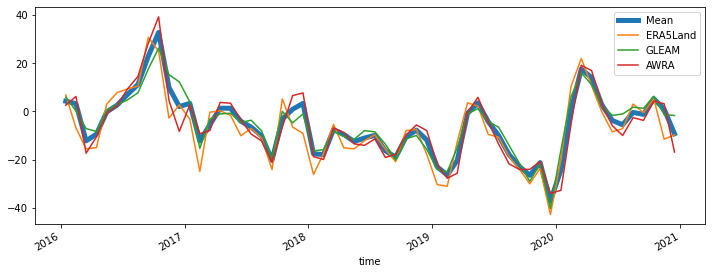

In [13]:
import matplotlib.pyplot as plt
da_E_monAnomAvg_regAvg.plot(size=4, aspect=3,label='Mean', linewidth=5)
era5land_anom_list[0].plot(label='ERA5Land')
gleam_anom_list[0].plot(label='GLEAM')
awra_anom_list[0].plot(label='AWRA')
plt.legend()

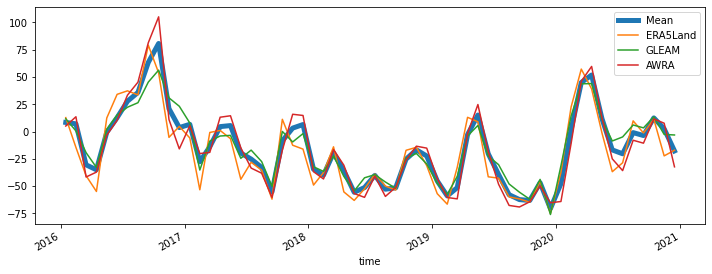

In [14]:
import matplotlib.pyplot as plt
da_perc_E_monAnomAvg_regAvg.plot(size=4, aspect=3,label='Mean', linewidth=5)
era5land_anom_list[1].plot(label='ERA5Land')
gleam_anom_list[1].plot(label='GLEAM')
awra_anom_list[1].plot(label='AWRA')
plt.legend()

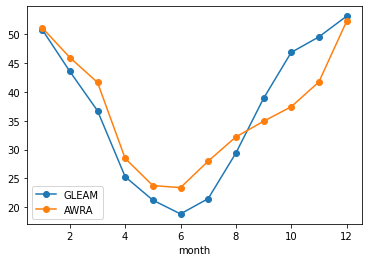

In [15]:
#calc_areaAvg(da_era5land_lt_monClim).plot(label='ERA5Land')
calc_areaAvg(da_gleam_lt_monClim*da_gleam_mask).plot(label='GLEAM', marker='o')
calc_areaAvg(da_awra_lt_monClim*da_awra_mask).plot(label='AWRA', marker="o")
plt.legend()

### The bars on the below plots show monthly data with AMJJAS season highlighted

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

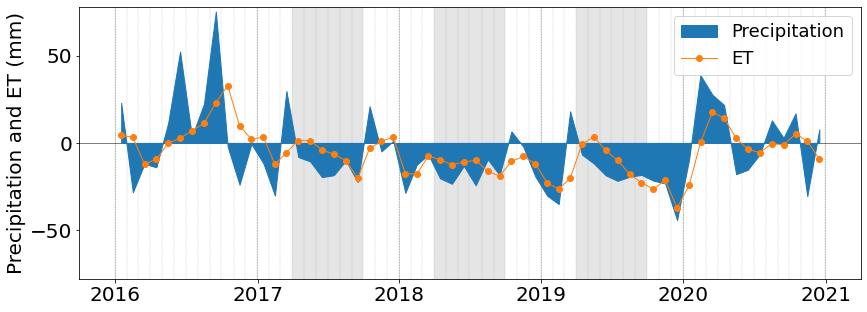

In [112]:
out_dir = 'figures/drought_2017to2020/timeseries_plots/'
col_sel = ['gray', 'orange', 'royalblue']
data_list = [da_precip_monAnomAvg_regAvg, da_E_monAnomAvg_regAvg]
data_names = ['Precipitation', 'ET']
data_col = sns.color_palette()[0:2] #['royalblue', 'orange']

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

AMJJAS_fillcol = 'grey'
AMJJAS_alpha = 0.2
mon_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1)#.to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6)#.to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

# Add a filled line plot for the first data
for da, color, label in zip([data_list[0]], [data_col[0]], [data_names[0]]):
    ax.fill_between(da.time.values, 0, da.values, color=color, label=label, zorder = 2, alpha = 1)
    # plt.plot(da.time.values, da.values, marker='o', color=color, label=label, linewidth=1, zorder = 5)

# keep ET as a line plot
for da, color, label in zip([data_list[1]], [data_col[1]], [data_names[1]]):       
    plt.plot(da.time.values, da.values, marker='o', color=color, label=label, linewidth=1, zorder = 3)    
    
plt.xlabel('')
plt.ylabel('Precipitation and ET (mm)')
plt.ylim((-78, 78))

#********** shading the background to indicate the AMJJAS seasons within 2017-19 instead
dx = mon_breaks
# adding march in the below code as breaks are at the end of the month
fill = (mon_breaks.month.isin([3, 4, 5, 6, 7, 8, 9])) & (mon_breaks.year.isin([2017, 2018, 2019]))
ax.fill_between(dx, ax.get_ylim()[0], ax.get_ylim()[1], where=fill, fc=AMJJAS_fillcol, alpha=AMJJAS_alpha, zorder = 1)
#**********

plt.legend(loc=1)

fig.savefig(out_dir + 'areaAvg_precip_and_ET_anom_from_monClim.png', bbox_inches='tight', dpi=300)
fig.savefig(out_dir + 'areaAvg_precip_and_ET_anom_from_monClim.pdf', bbox_inches='tight', format='pdf')

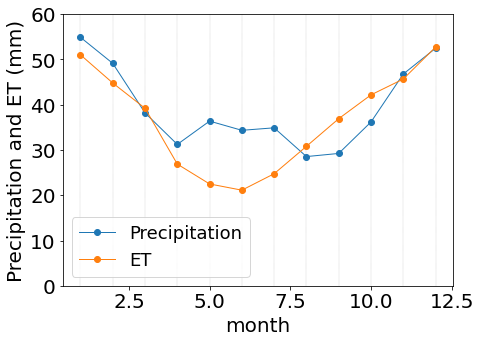

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height

data_list_P_monClim = [calc_areaAvg(da_agcd_lt_monClim*da_agcd_mask), 
                       calc_areaAvg(da_chirps_lt_monClim*da_chirps_mask), 
                       calc_areaAvg(da_mswep_lt_monClim*da_mswep_mask)]
da_P_monClim = xr.concat(data_list_P_monClim, dim = 'dataset').mean('dataset')

data_list_E_monClim = [calc_areaAvg(da_gleam_lt_monClim*da_gleam_mask), 
                       calc_areaAvg(da_awra_lt_monClim*da_awra_mask)]
da_E_monClim = xr.concat(data_list_E_monClim, dim = 'dataset').mean('dataset')

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)

data_list = [da_P_monClim, da_E_monClim]
    
for da, color, label in zip(data_list, data_col, data_names):  
    plt.plot(da.month.values, da.values, color=color, marker="o", linewidth=1, label=label)

plt.xlabel('month')
plt.ylabel('Precipitation and ET (mm)')
plt.ylim((0, 60))
plt.legend(loc=0)

# fig.savefig(out_dir + 'precip_and_ET_monClim_1980to2016.png', bbox_inches='tight', dpi=300)
# fig.savefig(out_dir + 'precip_and_ET_monClim_1980to2016.pdf', bbox_inches='tight', format='pdf')

### Anomalies in %

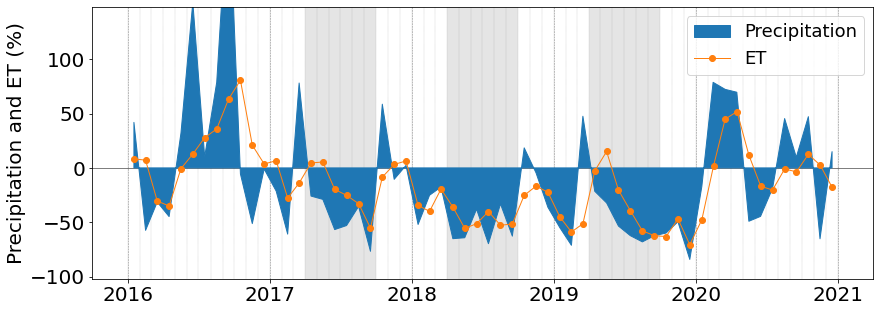

In [111]:
out_dir = 'figures/drought_2017to2020/timeseries_plots/'
col_sel = ['gray', 'orange', 'royalblue']
data_list = [da_perc_precip_monAnomAvg_regAvg, da_perc_E_monAnomAvg_regAvg]
data_list_anom = [da_precip_monAnomAvg_regAvg, da_E_monAnomAvg_regAvg]
data_list_clim = [da_P_monClim, da_E_monClim]
data_names = ['Precipitation', 'ET']
data_col = sns.color_palette()[0:2] #['royalblue', 'orange']

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

mon_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1)#.to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6)#.to_numpy()
    
for xline in mon_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

#for da, color, label in zip(data_list, data_col, data_names):       

ax.fill_between(data_list[0].time.values, 0, data_list[0].values, color=data_col[0], label=data_names[0], zorder = 2, alpha = 1)
plt.plot(data_list[1].time.values, data_list[1].values, marker='o', color=data_col[1], label=data_names[1], linewidth=1, zorder = 3)

plt.xlabel('')
plt.ylabel('Precipitation and ET (%)')
plt.ylim((-102, 148))

#********** shading the background to indicate the AMJJAS seasons within 2017-19 instead
dx = mon_breaks
# adding march in the below code as breaks are at the end of the month
fill = (mon_breaks.month.isin([3, 4, 5, 6, 7, 8, 9])) & (mon_breaks.year.isin([2017, 2018, 2019]))
ax.fill_between(dx, ax.get_ylim()[0], ax.get_ylim()[1], where=fill, fc=AMJJAS_fillcol, alpha=AMJJAS_alpha, zorder = 1)
#**********

plt.legend(loc=1)

fig.savefig(out_dir + 'areaAvg_precip_and_ET_perc_anom_from_monClim.png', bbox_inches='tight', dpi=300)
fig.savefig(out_dir + 'areaAvg_precip_and_ET_perc_anom_from_monClim.pdf', bbox_inches='tight', format='pdf')

### Precip Anomalies in % (to mention in the text)
#### AMJJAS & DJF seasons (these would be the most useful)

In [23]:
data_list = [da_precip_monAnomAvg_regAvg, da_E_monAnomAvg_regAvg]

AMJJAS_time = pd.date_range(start = '2016-06-30', end = '2020-06-30', periods=5).to_numpy()
AMJJAS_time = [x.astype('datetime64[D]') for x in AMJJAS_time]

DJF_time = pd.date_range(start = '2017-01-15', end = '2020-01-15', periods=4).to_numpy()
DJF_time = [x.astype('datetime64[D]') for x in DJF_time]

AMJJAS_bars = []
mon_sel = [4, 5, 6, 7, 8, 9]
for da in data_list:
    da_sel = da.sel(time = da.time.dt.month.isin(mon_sel))
    da_AMJJAS_byyear = da_sel.groupby('time.year').mean()
    AMJJAS_bars.append(da_AMJJAS_byyear.values)

DJF_bars = []
mon_sel = [12, 1, 2]
for da in data_list:
    da_seas_temp = da.resample(time="QS-DEC").mean()
    da_seas_sel = da_seas_temp.sel(time = da_seas_temp.time.dt.month.isin([12, 1, 2]))
    DJF_bars.append(da_seas_sel.values[1:-1])
    
mon_sel = [4, 5, 6, 7, 8, 9]
P_AMJJAS_clim = da_P_monClim.sel(month = da_P_monClim.month.isin(mon_sel)).mean()
E_AMJJAS_clim = da_E_monClim.sel(month = da_E_monClim.month.isin(mon_sel)).mean()

mon_sel = [12, 1, 2]
P_DJF_clim = da_P_monClim.sel(month = da_P_monClim.month.isin(mon_sel)).mean()
E_DJF_clim = da_E_monClim.sel(month = da_E_monClim.month.isin(mon_sel)).mean()

In [24]:
df_anom = pd.DataFrame({'season':['AMJJAS']*5,
                        'time': AMJJAS_time,
                        'anomaly (mm)': np.round(AMJJAS_bars[0], 2),
                        'perc_anomaly (%)': np.round(AMJJAS_bars[0]/P_AMJJAS_clim.values*100,1),
                       'climatology (mm)': [np.round(P_AMJJAS_clim.values, 2)]*5})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/AMJJAS_precip_anomalies.csv'
#df_anom.to_csv(out_file)

   season       time  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  AMJJAS 2016-06-30         25.24              77.8             32.42
1  AMJJAS 2017-06-30        -14.92             -46.0             32.42
2  AMJJAS 2018-06-30        -18.22             -56.2             32.42
3  AMJJAS 2019-06-30        -16.12             -49.7             32.42
4  AMJJAS 2020-06-30         -0.39              -1.2             32.42


In [25]:
df_anom = pd.DataFrame({'season':['DJF']*4,
                        'time': DJF_time,
                        'anomaly (mm)': np.round(DJF_bars[0], 2),
                        'perc_anomaly (%)': np.round(DJF_bars[0]/P_DJF_clim.values*100,1),
                       'climatology (mm)': [np.round(P_DJF_clim.values, 2)]*4})
print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/DJF_precip_anomalies.csv'
#df_anom.to_csv(out_file)

  season       time  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0    DJF 2017-01-15        -14.21             -27.3             52.13
1    DJF 2018-01-15        -13.36             -25.6             52.13
2    DJF 2019-01-15        -28.17             -54.0             52.13
3    DJF 2020-01-15         -4.94              -9.5             52.13


In [26]:
da_anom_allDatamean = da_precip_monAnomAvg_regAvg
da_clim_allDatamean = da_P_monClim

anom_seasMean = da_anom_allDatamean.resample(time="QS-DEC").mean()
clim_seasMean = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_anom_allDatamean.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (mm)': np.round(anom_seasMean, 2).values,
                        'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (mm)': np.round(clim_seasMean, 2).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_precip_anomalies.csv'
#df_anom.to_csv(out_file)

       season  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  2015-12-01         -2.68              -5.1             51.98
1  2016-03-01         -4.84             -13.7             35.25
2  2016-06-01         26.17              80.3             32.58
3  2016-09-01         16.42              43.9             37.37
4  2016-12-01        -14.21             -27.3             52.13
5  2017-03-01          3.70              10.5             35.25
6  2017-06-01        -16.11             -49.5             32.58
7  2017-09-01         -2.12              -5.7             37.37
8  2017-12-01        -13.36             -25.6             52.13
9  2018-03-01        -16.86             -47.8             35.25
10 2018-06-01        -15.68             -48.1             32.58
11 2018-09-01         -4.67             -12.5             37.37
12 2018-12-01        -28.17             -54.0             52.13
13 2019-03-01         -0.14              -0.4             35.25
14 2019-06-01        -19.94             

In [27]:
da_anom_allDatamean = da_precip_monAnomAvg_regAvg
da_clim_allDatamean = da_P_monClim

anom_mon = da_anom_allDatamean
clim_mon = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_allDatamean.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (mm)': np.round(anom_mon, 2).values,
                        'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (mm)': np.round(clim_mon, 2).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/mon_precip_anomalies.csv'
#df_anom_mon.to_csv(out_file_mon)

                 month  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  2016-01-16 00:00:00         22.98              41.9             54.86
1  2016-02-15 00:00:00        -28.33             -57.7             49.11
2  2016-03-16 00:00:00        -12.04             -31.5             38.18
3  2016-04-15 12:00:00        -13.99             -44.8             31.21
4  2016-05-16 00:00:00         11.52              31.7             36.36
5  2016-06-15 12:00:00         52.45             152.8             34.32
6  2016-07-16 00:00:00          3.58              10.3             34.87
7  2016-08-16 00:00:00         22.46              78.7             28.53
8  2016-09-15 12:00:00         75.39             258.0             29.22
9  2016-10-16 00:00:00         -2.12              -5.9             36.16
10 2016-11-15 12:00:00        -24.01             -51.4             46.75
11 2016-12-16 00:00:00         -0.62              -1.2             52.43
12 2017-01-16 00:00:00        -11.81             -2

### ET anomalies

In [28]:
df_anom = pd.DataFrame({'season':['AMJJAS']*5,
                        'time': AMJJAS_time,
                        'anomaly (mm)': np.round(AMJJAS_bars[1], 2),
                        'perc_anomaly (%)': np.round(AMJJAS_bars[1]/E_AMJJAS_clim.values*100,1),
                       'climatology (mm)': [np.round(E_AMJJAS_clim.values, 2)]*5})
print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/AMJJAS_ET_anomalies.csv'
#df_anom.to_csv(out_file)

df_anom = pd.DataFrame({'season':['DJF']*4,
                        'time': DJF_time,
                        'anomaly (mm)': np.round(DJF_bars[1], 2),
                        'perc_anomaly (%)': np.round(DJF_bars[1]/E_DJF_clim.values*100,1),
                       'climatology (mm)': [np.round(E_DJF_clim.values, 2)]*4})
print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/DJF_ET_anomalies.csv'
#df_anom.to_csv(out_file)

da_anom_allDatamean = da_E_monAnomAvg_regAvg
da_clim_allDatamean = da_E_monClim

anom_seasMean = da_anom_allDatamean.resample(time="QS-DEC").mean()
clim_seasMean = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_anom_allDatamean.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (mm)': np.round(anom_seasMean, 2).values,
                        'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (mm)': np.round(clim_seasMean, 2).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_ET_anomalies.csv'
#df_anom.to_csv(out_file)

da_anom_allDatamean = da_E_monAnomAvg_regAvg
da_clim_allDatamean = da_E_monClim

anom_mon = da_anom_allDatamean
clim_mon = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_allDatamean.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (mm)': np.round(anom_mon, 2).values,
                        'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (mm)': np.round(clim_mon, 2).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/mon_ET_anomalies.csv'
#df_anom_mon.to_csv(out_file_mon)

   season       time  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  AMJJAS 2016-06-30          5.70              21.0             27.15
1  AMJJAS 2017-06-30         -6.39             -23.5             27.15
2  AMJJAS 2018-06-30        -13.07             -48.2             27.15
3  AMJJAS 2019-06-30         -8.71             -32.1             27.15
4  AMJJAS 2020-06-30          0.97               3.6             27.15
  season       time  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0    DJF 2017-01-15         -2.31              -4.7             49.49
1    DJF 2018-01-15        -10.73             -21.7             49.49
2    DJF 2019-01-15        -20.43             -41.3             49.49
3    DJF 2020-01-15        -20.32             -41.1             49.49
       season  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  2015-12-01          3.75               7.8             47.88
1  2016-03-01         -7.28             -24.7             29.52
2  2016-06-01          6.95     

## Correlation between precipitation & Tmax during the Tinderbox drought

In [34]:
# get the tmax data
data_dir = '/g/data/w97/ad9701/drought_2017to2020/agcd_othervar/'

agcd_tmax = 'agcd_v1_tmax_mean_r005_monthly_1910_2021.nc'
ds_tmax = xr.open_dataset(data_dir + agcd_tmax)

# the monthly climatology from long-term data
# time_slice = slice('1981-01-01', '2020-05-31')
time_slice = slice('1980-01-01', '2016-12-31')  # using the agreed time reference
da_tmax_lt_monClim = ds_tmax['tmax'].sel(time = time_slice).groupby('time.month').mean('time')

# the monthly anomalies during the drought period
time_slice = slice('2016-01-01', '2020-12-31')
da_tmax_monAnom = ds_tmax['tmax'].sel(time = time_slice).groupby('time.month') - da_tmax_lt_monClim

# read mask from saved files
mask_file = '/g/data/w97/ad9701/drought_2017to2020/AGCD_mask_drought_focusArea.nc'
ds_agcd_mask = xr.open_dataset(mask_file)
da_agcd_mask = ds_agcd_mask['mask']

tmax_anom_list = calc_regAvg_monAnom_masked(da_tmax_monAnom, da_tmax_lt_monClim, da_agcd_mask)

In [107]:
da_tmax_monAnomAvg_regAvg = tmax_anom_list[0]

time_sel = slice('2017', '2019')

precip = pd.Series(da_precip_monAnomAvg_regAvg.sel(time = time_sel).values)
tmax = pd.Series(da_tmax_monAnomAvg_regAvg.sel(time = time_sel).values)

print(precip.corr(tmax))

import scipy.stats
scipy.stats.pearsonr(precip.values, tmax.values)

-0.3864998449254093


(-0.3864998449254093, 0.019887590618964154)

Text(0.8, 0.7, 'p-value = 0.02')

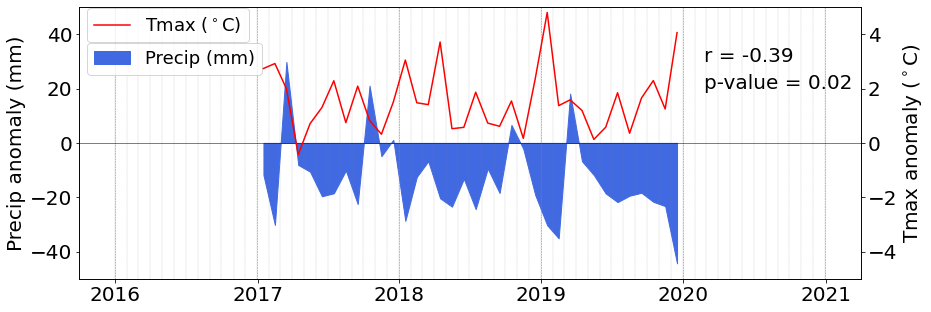

In [103]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

mon_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

label_list = ['Precip (mm)', 'Tmax ($^\circ$C)']
ylabel_list = ['Precip anomaly (mm)', 'Tmax anomaly ($^\circ$C)']
ylim_list = [(-50, 50), (-5, 5)]
data_list = [da_precip_monAnomAvg_regAvg.sel(time = time_sel),
             da_tmax_monAnomAvg_regAvg.sel(time = time_sel)]
             
for xline in mon_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

ax.fill_between(data_list[0].time.values, 0, data_list[0].values, label = label_list[0], color = 'royalblue')
plt.ylim(ylim_list[0])
plt.ylabel(ylabel_list[0])
plt.legend(loc = (0.01, 0.75))

ax2 = ax.twinx()
plt.ylim(ylim_list[1])
plt.ylabel(ylabel_list[1])
ax2.plot(data_list[1].time.values, data_list[1].values, label = label_list[1], color = 'red')
plt.legend(loc = (0.01, 0.87))

corr_pval = scipy.stats.pearsonr(data_list[0].values, data_list[1].values)
plt.text(0.8, 0.8, 'r = ' + str(round(corr_pval[0], 2)), transform=ax.transAxes)
plt.text(0.8, 0.7, 'p-value = ' + str(round(corr_pval[1], 2)), transform=ax.transAxes)

Text(0.8, 0.7, 'p-value = 0.16')

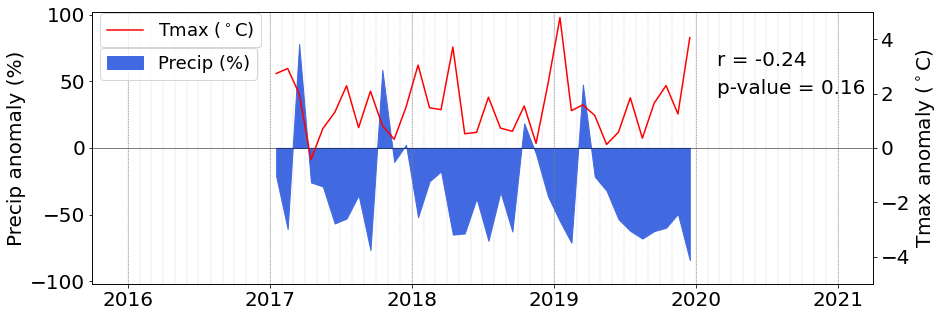

In [106]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

label_list = ['Precip (%)', 'Tmax ($^\circ$C)']
ylabel_list = ['Precip anomaly (%)', 'Tmax anomaly ($^\circ$C)']
ylim_list = [(-102, 102), (-5, 5)]
data_list = [da_perc_precip_monAnomAvg_regAvg.sel(time = time_sel),
             da_tmax_monAnomAvg_regAvg.sel(time = time_sel)]
             
for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

ax.fill_between(data_list[0].time.values, 0, data_list[0].values, label = label_list[0], color = 'royalblue')
plt.ylim(ylim_list[0])
plt.ylabel(ylabel_list[0])
plt.legend(loc = (0.01, 0.75))

ax2 = ax.twinx()
plt.ylim(ylim_list[1])
plt.ylabel(ylabel_list[1])
ax2.plot(data_list[1].time.values, data_list[1].values, label = label_list[1], color = 'red')
plt.legend(loc = (0.01, 0.87))

corr_pval = scipy.stats.pearsonr(data_list[0].values, data_list[1].values)
plt.text(0.8, 0.8, 'r = ' + str(round(corr_pval[0], 2)), transform=ax.transAxes)
plt.text(0.8, 0.7, 'p-value = ' + str(round(corr_pval[1], 2)), transform=ax.transAxes)